## Imports

In [126]:
import collections
import os
import string
import sys
import nltk

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

nltk.download('punkt')

import sys
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alicemahiant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [127]:
data_path = "../data/txt/"

## Choosing a decade

In [128]:
DECADE = '1960'

## Charging all the decade's files and making it a list of texts

In [129]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [130]:
texts = [open(data_path + f).read() for f in files]

## Vectorizing the files with TF-IDF

In [131]:
# creating a pre-treatment function
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instanciating the TF-IDF model with its arguments

In [132]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Constructing the matrice with the `fit_transform` function

In [133]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [134]:
# details about the matrice
tfidf_vectors

<1000x2997 sparse matrix of type '<class 'numpy.float64'>'
	with 591250 stored elements in Compressed Sparse Row format>

## Applying a clustering algorithm on the TF-IDF vectors of the documents

### Setting the number of clusters

In [193]:
N_CLUSTERS = 3

### Instanciate the K-Means model and its arguments

In [194]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Applying the clustering with the function `fit_predict`

In [195]:
clusters = km_model.fit_predict(tfidf_vectors)

In [196]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

## Visualizing the clusters

### Reducing the vectors to 2D with the PCA algorithm

In [197]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

### Generating the plot

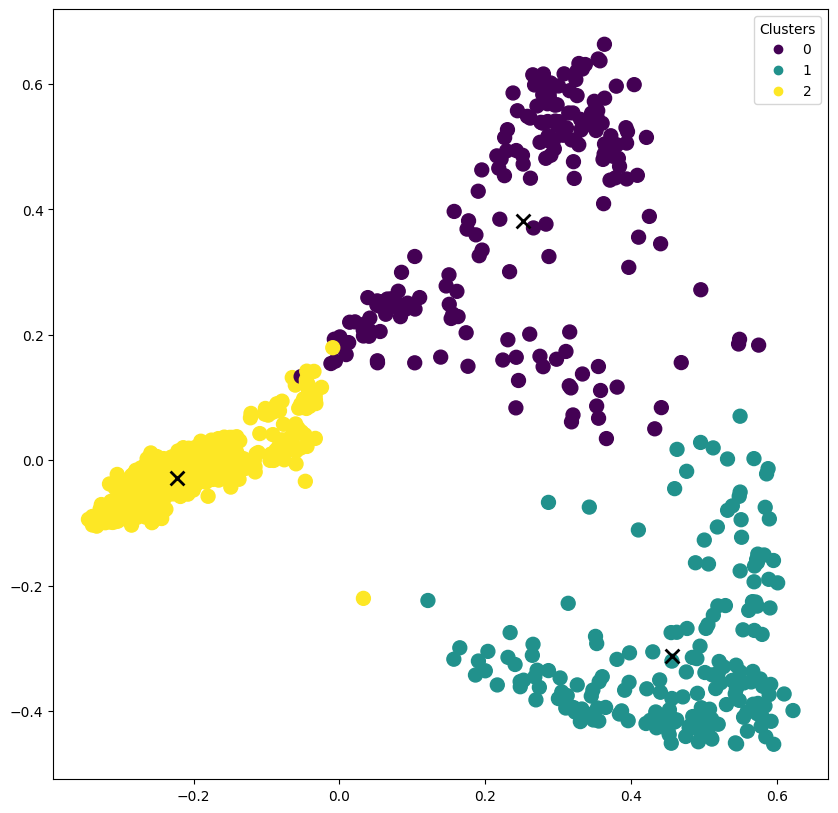

In [198]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Words embeddings

## Segmentation in sentences : input and output files

In [141]:
infile = "../data/txt/all.txt"
outfile = "../data/sents.txt"

## Charging and treating the corpus's sentences

### Creating an object *streaming* the file's lines to save RAM

In [142]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [143]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

### Detecting the bigrams

In [144]:
bigram_phrases = Phrases(sentences)

In [145]:
type(bigram_phrases.vocab)

dict

### Printing the numbers of keys (= different terms) observed in the corpus

In [146]:
len(bigram_phrases.vocab.keys())

15761694

### Let's have a look at a random key :

In [147]:
key_ = list(bigram_phrases.vocab.keys())[5]
print(key_)

exemplaires


### The dictionnary shows the score of this cooccurence :

In [148]:
bigram_phrases.vocab[key_]

584

### Conversion of the `Phrases` into an object `Phraser`

In [149]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

## Trigrams extraction

### Repeating the operation with the bigrams list to extract trigrams

In [150]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [151]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Creating a corpus of unigrams, bigrams and trigrams

In [152]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

In [153]:
print(corpus[:100])

[['raege', 'quotidien', 'j00', 'exemplaires_distribues', 'gratuitement', '#', 'k', '.', "'", 'dans', 'ilagg', ';', 'lomeration', 'bruxelloise', 'et', '.', 'en_province', '.'], ['i', 'personnes_habitant', 'aux_etages', 'fenile', 'journal_contre', '60', 'c', '"<<', 'par_mois', '.'], ['fspir', 'est', 'expedie', 'en', 'proyinoe', 'contre', 't', '*>>"', 'par_mois', ',', 'payables_par_trimestre', '.'], ['annonces', ',', 'faits_divers', 'et', 'reclames', 'sjont', 'recu', 'frie', 'd', "'", 'isabelle', ';', 'a', 'l', "'", 'agence', 'rossfjl', '.'], ['44', '.'], ['-', 'v', ',', 'et', 'do', 'l', "'", 'enseignement', ',', 'a', 'braxell', 'annonces_remises_avant', 'midi', 'sont', ';', '-', 'a', ";'%", '>', '1', 'v', '>>^.'], [':', 'vv', '*', "*'*", 'hv', '/', 'f', '#-', 'v', '1', 'v', ';', "'", 'y', '>', 'fif', "'", 'ji', 'l', "'", 'h', '-', 'et', '.'], ['jeudi', '22', 'decembre', 'i887', 'observatoire', 'roy', "&'", 'cs', 'io', 'decembre', 's', 'heurts', 'uat', '$', 'r', '-:', 'r', 'quotidien_grat

## Training a Word2Vec model onto this corpus

In [154]:
%%time
model = Word2Vec(
    corpus, # setting the ngrams corpus we just created
    vector_size=32, # setting the number of dimensions into which the context of the words should be reducted, aka. vector_size
    window=5, # setting the context size, aka. the window
    min_count=5, # ignoring the words appearing less than 5 times in the corpus
    workers=4, # parallelizing the training in 4 threads
    epochs=5 # setting the number of neural network iterations on the dataset to adjust parameters with gradient descent, aka. epochs
)

CPU times: user 4min 31s, sys: 3.8 s, total: 4min 35s
Wall time: 1min 40s


### Saving the model in a file

In [155]:
outfile = f"../data/newspapers.model"
model.save(outfile)

## Exploring the model

### Charging the model previously saved

In [156]:
model = Word2Vec.load("../data/newspapers.model")

### Printing the vector of a random word

In [157]:
model.wv["premier"]

array([ 2.6499248e+00,  1.9608245e+00, -9.6356027e-02, -1.2720468e+00,
       -1.8542490e-03,  7.4017721e-01, -3.0940682e-01, -1.9058081e+00,
        3.1072351e-01, -1.1075560e+00,  6.0100722e-01, -1.6125675e-01,
       -2.3747280e+00, -1.2825590e+00, -5.3127831e-01,  1.2456630e+00,
       -3.5616219e+00,  1.2080455e+00, -4.3192568e-01,  9.8714882e-01,
       -9.8142964e-01,  2.5245275e+00, -2.3744936e+00,  4.3287740e+00,
        7.2968215e-01,  5.3063707e+00, -2.6731310e+00,  1.9746448e+00,
        2.3596449e+00, -3.3180244e+00,  2.4469672e-01,  7.1251988e-01],
      dtype=float32)

### Measuring the similarity between two words for three different associations

In [158]:
model.wv.similarity("firme", "fiat")

-0.04598973

In [159]:
model.wv.similarity("division", "equipe")

0.7827908

In [203]:
model.wv.similarity("premier", "sportif")

0.7089716

### Looking for the first 10 most similar words for three different words

In [205]:
model.wv.most_similar("partir", topn=10)

[('dater', 0.7124831676483154),
 ('quinzaine', 0.6698272824287415),
 ('chaque_acheteur', 0.6532112956047058),
 ('100_francs', 0.6486285328865051),
 ('vos_vacances', 0.6463161706924438),
 ('paques', 0.6429856419563293),
 ('ce_jour', 0.6418842673301697),
 ('chaque_mois', 0.6362062692642212),
 ('vendue', 0.631614089012146),
 ('votre_choix', 0.6304603219032288)]

In [162]:
model.wv.most_similar("aide", topn=10)

[('expediteur', 0.7761807441711426),
 ('infirmiere', 0.7069873213768005),
 ('hotesse', 0.6964925527572632),
 ('diriger', 0.6958692073822021),
 ('alde', 0.6917549967765808),
 ('laveur', 0.6856649518013),
 ('jeune_aide', 0.6837157607078552),
 ('surveillant', 0.678504228591919),
 ('infirmier', 0.6783333420753479),
 ('econome', 0.6768307089805603)]

In [163]:
model.wv.most_similar("frs", topn=10)

[('fr', 0.8976708650588989),
 ('centime', 0.8280691504478455),
 ('000_franc', 0.820595920085907),
 ('franos', 0.8164003491401672),
 ('fir', 0.8136240839958191),
 ('grs', 0.8104934692382812),
 ('cigares_dechets', 0.8012471795082092),
 ('m3', 0.788710355758667),
 ('volts', 0.7879461050033569),
 ('009', 0.7870420813560486)]